In [1]:
from pulp import *
from ALB_instance_tools import *
from MDP_functions import *
import numpy as np

# MDP model
taken from Markov decision process for multi-manned mixed-model assembly lines with walking workers Hasemi-Petroodi et. al. 2022

In [2]:
instance_names = [
    "SALBP_benchmark/small data set_n=20/instance_n=20_1.alb",
    "SALBP_benchmark/small data set_n=20/instance_n=20_2.alb",
]
# instance_names = ['SALBP_benchmark/debugging_ds/instance_n=3_1.alb','SALBP_benchmark/debugging_ds/instance_n=3_2.alb' ]
test_instances = create_instance_pairs(instance_names)
# Parameters
WORKER_COST = 200
NO_EQUIPMENT = 4
NO_S = 2
C_EM = 150
NO_MODELS = 2
TAKT_TIME = 200  # cadence to respect
MAX_L = 3  # maximum number of workers at a station
# STATION_MODEL_PICTURES  = {}

S_E = [(s, e) for s in range(NO_S) for e in range(NO_EQUIPMENT)]
S_L = [(s, l) for s in range(NO_S) for l in range(1, MAX_L)]

NO_CONFIG = NO_MODELS**NO_S  # Number of possible line pictures

test_instances[0] = eliminate_tasks(test_instances[0], (0.7, 0.8))
for i in range(NO_MODELS):
    test_instances[0][i]["cycle_time"] = TAKT_TIME
    test_instances[0][i]["c_em"] = C_EM
    test_instances[0][i]["max_workers"] = MAX_L

all_tasks = list_all_tasks(test_instances[0])

c_se, r_oe = generate_equipment(NO_EQUIPMENT, NO_S, all_tasks)
stations = list(range(NO_S))
models = list(range(NO_MODELS))
model_pairs = list(itertools.combinations(models, 2))
omega = []
enumerate_universe("", omega, NO_MODELS, NO_S)
actions = list(range(len(all_tasks) ** NO_S))
# equipment = list(range(NO_EQUIPMENT))
# workers = list(range(1, MAX_L+1))

/var/folders/6v/7nrd1rj91hx3tb4q5npbdf0w0000gn/T/ipykernel_315/2549244396.py:6: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


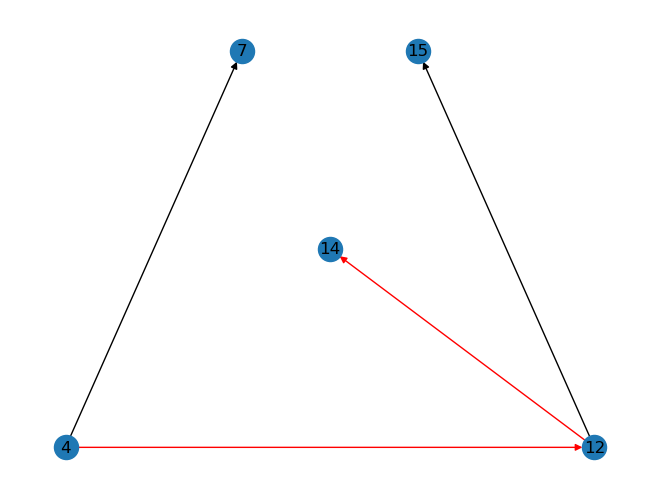

In [3]:
p_graph = nx.DiGraph()
p_graph.add_edges_from(test_instances[0][0]["precedence_relations"], color="r")
p_graph.add_edges_from(test_instances[0][1]["precedence_relations"], color="k")
colors = [p_graph[u][v]["color"] for u, v in p_graph.edges]
nx.draw_planar(p_graph, edge_color=colors, with_labels=True)
plt.tight_layout()
# plt.savefig("precedence_graph.png", format="PNG" )

NameError: name 'copy' is not defined

## MDP State
### State variables
F_isd -- Equal to 1 when model i is located at station s in state d, 0 otherwise

P_osd -- equal to 1 if model 1 if task o has been already executed for the the model in station s when the sytem passed to state d, 0 otherwise


R_osa -- equal to 1 if action a performs task o on the model in station s



### Transistion variables
Tr_a_d_dprime -- probability to transistion from state d to state d' with action a


### Other parameters
q_as -- number of workers required in station s for action a






## STATE markov decision process

In [ ]:
no_line_pictures = len(omega)

4

In [ ]:
feasible_partitions = get_feasible_partitions(
    models, NO_S, all_tasks, test_instances[0]
)
model_histories = create_model_histories(feasible_partitions, models, NO_S)
D = create_D(omega, model_histories, NO_S)
A = create_A(D, model_histories, test_instances[0], TAKT_TIME, MAX_L, NO_S)

print(
    "length of A",
    len(A),
    "length of omega",
    len(omega),
    "no_line_pictures",
    no_line_pictures,
)

{'model_0': [{'index': 0, 'station_0': [], 'station_1': ['20', '13', '4']},
  {'index': 1, 'station_0': [], 'station_1': ['20', '4', '19']},
  {'index': 2, 'station_0': [], 'station_1': ['20', '4', '3']},
  {'index': 3, 'station_0': [], 'station_1': ['20', '4']},
  {'index': 4, 'station_0': [], 'station_1': ['13', '4', '19', '3']},
  {'index': 5, 'station_0': [], 'station_1': ['13', '4', '19']},
  {'index': 6, 'station_0': [], 'station_1': ['13', '4', '3']},
  {'index': 7, 'station_0': [], 'station_1': ['13', '4']},
  {'index': 8, 'station_0': [], 'station_1': ['13', '3']},
  {'index': 9, 'station_0': [], 'station_1': ['4', '19', '3']},
  {'index': 10, 'station_0': [], 'station_1': ['4', '19']},
  {'index': 11, 'station_0': [], 'station_1': ['4', '3']},
  {'index': 12, 'station_0': [], 'station_1': ['4']}],
 'model_1': [{'index': 0,
   'station_0': [],
   'station_1': ['20', '13', '4', '19']},
  {'index': 1, 'station_0': [], 'station_1': ['20', '13', '4', '3']},
  {'index': 2, 'station

# MDP MILP
whew, finally

### Decision Variables

W_se -- 1 if equipment e is chosen for station s, 0 otherwise

X_ad -- probability of taking action a in state d

### Other variables
y_asoi -- 1 if task o is at station s for model i during action a

In [ ]:
# Decision Variables
X_ad = LpVariable.dicts(
    "X_ad",
    (action["action_index"] for action in A),
    lowBound=0,
    upBound=1,
    cat=LpContinuous,
)
W_se = LpVariable.dicts("W_se", (S_E), lowBound=0, upBound=1, cat=LpBinary)

In [ ]:
prob = LpProblem("MDP", LpMinimize)
prob += (
    lpSum(
        [
            X_ad[action["action_index"]] * WORKER_COST * action["total_workers"]
            for action in A
        ]
        + [W_se[s, e] * c_se[s, e] for s, e in S_E]
    ),
    "Total Cost",
)

for d_prime in D:
    d_prime_indices = [
        action["action_index"]
        for action in A
        if action["state_index"] == d_prime["index"]
    ]
    # constraint 3
    prob += (
        lpSum(
            [
                X_ad[action["action_index"]]
                * state_transistion_probability(
                    action, D[int(action["state_index"])], d_prime, NO_S
                )
                for action in A
            ]
        )
        == lpSum([X_ad[action] for action in d_prime_indices]),
        f"State_{d_prime['index']}_probability",
    )
# constraint 4
prob += (
    lpSum([X_ad[action["action_index"]] for action in A]) == 1,
    "Sum of probabilities",
)
for station in range(NO_S):
    for o, task in enumerate(all_tasks):
        for model in range(NO_MODELS):
            for d in D:
                for a in A:
                    if (
                        d["index"] == a["state_index"]
                        and d["model_at_" + str(station)]
                        == a["model_at_" + str(station)]
                        and task in a["action_at_" + str(station)]
                    ):
                        y_asoi = 1
                        # constraint 5
                        prob += (
                            y_asoi * X_ad[a["action_index"]]
                            <= lpSum(
                                [
                                    r_oe[o][equipment] * W_se[station, equipment]
                                    for equipment in range(NO_EQUIPMENT)
                                ]
                            ),
                            f"equipment_for_o_{task}_i_{model}_s_{station}_d_{d['index']}_a_{a['action_index']}",
                        )


{'model_at_0': '0', 'history_at_0': [], 'model_at_1': '0', 'history_at_1': ['13', '3'], 'index': 0}

{'model_at_0': '0', 'history_at_0': [], 'model_at_1': '0', 'history_at_1': ['3', '4'], 'index': 1}

{'model_at_0': '0', 'history_at_0': [], 'model_at_1': '0', 'history_at_1': ['13', '19', '4'], 'index': 2}

{'model_at_0': '0', 'history_at_0': [], 'model_at_1': '0', 'history_at_1': ['19', '20', '4'], 'index': 3}

{'model_at_0': '0', 'history_at_0': [], 'model_at_1': '0', 'history_at_1': ['13', '3', '4'], 'index': 4}

{'model_at_0': '0', 'history_at_0': [], 'model_at_1': '0', 'history_at_1': ['19', '4'], 'index': 5}

{'model_at_0': '0', 'history_at_0': [], 'model_at_1': '0', 'history_at_1': ['13', '20', '4'], 'index': 6}

{'model_at_0': '0', 'history_at_0': [], 'model_at_1': '0', 'history_at_1': ['13', '4'], 'index': 7}

{'model_at_0': '0', 'history_at_0': [], 'model_at_1': '0', 'history_at_1': ['4'], 'index': 8}
current_state {'model_at_0': '0', 'history_at_0': [], 'model_at_1': '0', 'h

In [ ]:
prob.solve(solver=XPRESS_PY(export="model.lp"))

Using the license file found in your Xpress installation. If you want to use this license and no longer want to see this message, use the following code before using the xpress module:
  xpress.init('/Applications/FICO Xpress/xpressmp/bin/xpauth.xpr')
FICO Xpress v9.0.3, Community, solve started 14:14:22, Jun 7, 2023
Heap usage: 1289KB (peak 1321KB, 521KB system)
Minimizing MILP noname using up to 8 threads and up to 8192MB memory, with these control settings:
OUTPUTLOG = 1
Original problem has:
      1991 rows          169 cols         9695 elements         8 entities
Presolved problem has:
       145 rows           32 cols          655 elements         8 entities
LP relaxation tightened
Presolve finished in 0 seconds
Heap usage: 1118KB (peak 2364KB, 521KB system)

Coefficient range                    original                 solved        
  Coefficients   [min,max] : [ 4.00e-01,  1.00e+00] / [ 1.00e-01,  1.75e+00]
  RHS and bounds [min,max] : [ 1.00e+00,  1.00e+00] / [ 2.50e-01,  1.

1

In [ ]:
for v in prob.variables():

    print(v.name, v.varValue)

W_se_(0,_0) -0.0
W_se_(0,_1) -0.0
W_se_(0,_2) -0.0
W_se_(0,_3) 1.0
W_se_(1,_0) 1.0
W_se_(1,_1) -5.551115123125783e-17
W_se_(1,_2) -0.0
W_se_(1,_3) -0.0
X_ad_0_0 0.0
X_ad_0_1 0.0
X_ad_0_10 0.0
X_ad_0_11 0.0
X_ad_0_12 0.0
X_ad_0_2 0.0
X_ad_0_3 0.0
X_ad_0_4 0.0
X_ad_0_5 0.0
X_ad_0_6 0.0
X_ad_0_7 0.0
X_ad_0_8 0.0
X_ad_0_9 0.0
X_ad_12_39 0.0
X_ad_12_40 0.0
X_ad_12_41 0.0
X_ad_12_42 0.0
X_ad_12_43 0.0
X_ad_12_44 0.0
X_ad_12_45 0.0
X_ad_12_46 0.0
X_ad_12_47 0.0
X_ad_12_48 0.0
X_ad_12_49 0.0
X_ad_12_50 0.0
X_ad_12_51 0.0
X_ad_13_52 0.0
X_ad_13_53 0.0
X_ad_13_54 0.0
X_ad_13_55 0.0
X_ad_13_56 0.0
X_ad_13_57 0.0
X_ad_13_58 0.0
X_ad_13_59 0.0
X_ad_13_60 0.0
X_ad_13_61 0.0
X_ad_13_62 0.0
X_ad_13_63 0.0
X_ad_13_64 -5.551115123125783e-17
X_ad_17_65 0.0
X_ad_17_66 0.0
X_ad_17_67 0.0
X_ad_17_68 0.0
X_ad_17_69 0.0
X_ad_17_70 0.0
X_ad_17_71 0.0
X_ad_17_72 0.0
X_ad_17_73 0.0
X_ad_17_74 0.0
X_ad_17_75 0.0
X_ad_17_76 0.0
X_ad_17_77 0.24000000000000002
X_ad_19_78 0.0
X_ad_19_79 0.0
X_ad_19_80 0.0
X_ad_19_81 